In [1]:
import keras
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import opendatasets as od

Using TensorFlow backend.


In [137]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
os.listdir('aptos2019-blindness-detection/')

['test_images',
 '.DS_Store',
 'test.csv',
 'train.csv',
 'train_images',
 'sample_submission.csv']

### Read data

In [21]:
train_df = pd.read_csv('aptos2019-blindness-detection/train.csv')

In [22]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Check the number of images and class distribution

In [23]:
train_df.shape

(3662, 2)

In [52]:
# group by classes
train_nodr = train_df[train_df['diagnosis']==0]
train_mild = train_df[train_df['diagnosis']==1]
train_moderate = train_df[train_df['diagnosis']==2]
train_severe = train_df[train_df['diagnosis']==3]
train_proliferative = train_df[train_df['diagnosis']==4]
train_nodr.reset_index(drop=True,inplace=True)
train_mild.reset_index(drop=True,inplace=True)
train_moderate.reset_index(drop=True,inplace=True)
train_severe.reset_index(drop=True,inplace=True)
train_proliferative.reset_index(drop=True,inplace=True)

In [58]:
labels = ['No_DR','Mild','Moderate','Severe','Proliferative_DR']
# # for i in range(5):
# #     path_to_save = os.path.join('aptos2019-blindness-detection/train_images/',labels[i])
# #     os.mkdir(path_to_save)
# for i in range(1,5):
#     temp_df = train_df[train_df['diagnosis']==i]
#     for index, row in temp_df.iterrows():
#         image = PIL.Image.open(os.path.join('aptos2019-blindness-detection/train_images/',row['id_code']+'.png'))
#         path_to_save = os.path.join('aptos2019-blindness-detection/train_images/',labels[i])
# #         os.mkdir(path_to_save)
#         image.save(os.path.join(path_to_save, row['id_code']+'.png'))
    
    

Text(0, 0.5, 'Number of images')

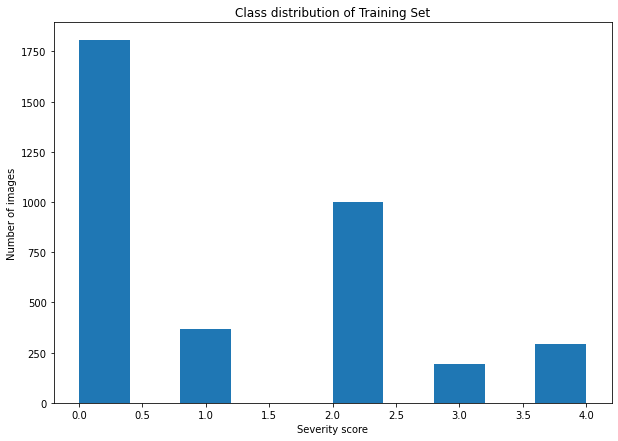

In [59]:
figure = plt.figure(figsize=(10,7))
plt.hist(train_df['diagnosis'])
plt.title('Class distribution of Training Set')
plt.xlabel('Severity score')
plt.ylabel('Number of images')

### Perform data visualization

In [60]:
train_nodr['diagnosis']

0       0
1       0
2       0
3       0
4       0
       ..
1800    0
1801    0
1802    0
1803    0
1804    0
Name: diagnosis, Length: 1805, dtype: int64

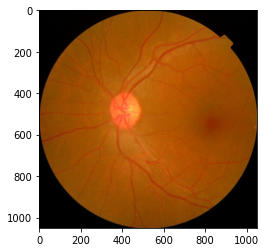

In [61]:
# fig, ax = plt.subplots(5,5)
images = os.listdir('aptos2019-blindness-detection/train_images/')
# print(type(images))
for i in range(1,5):
    im_path = os.path.join('aptos2019-blindness-detection/train_images/', train_nodr['id_code'][i]+'.png')
    im = PIL.Image.open(im_path)
    plt.imshow(im)

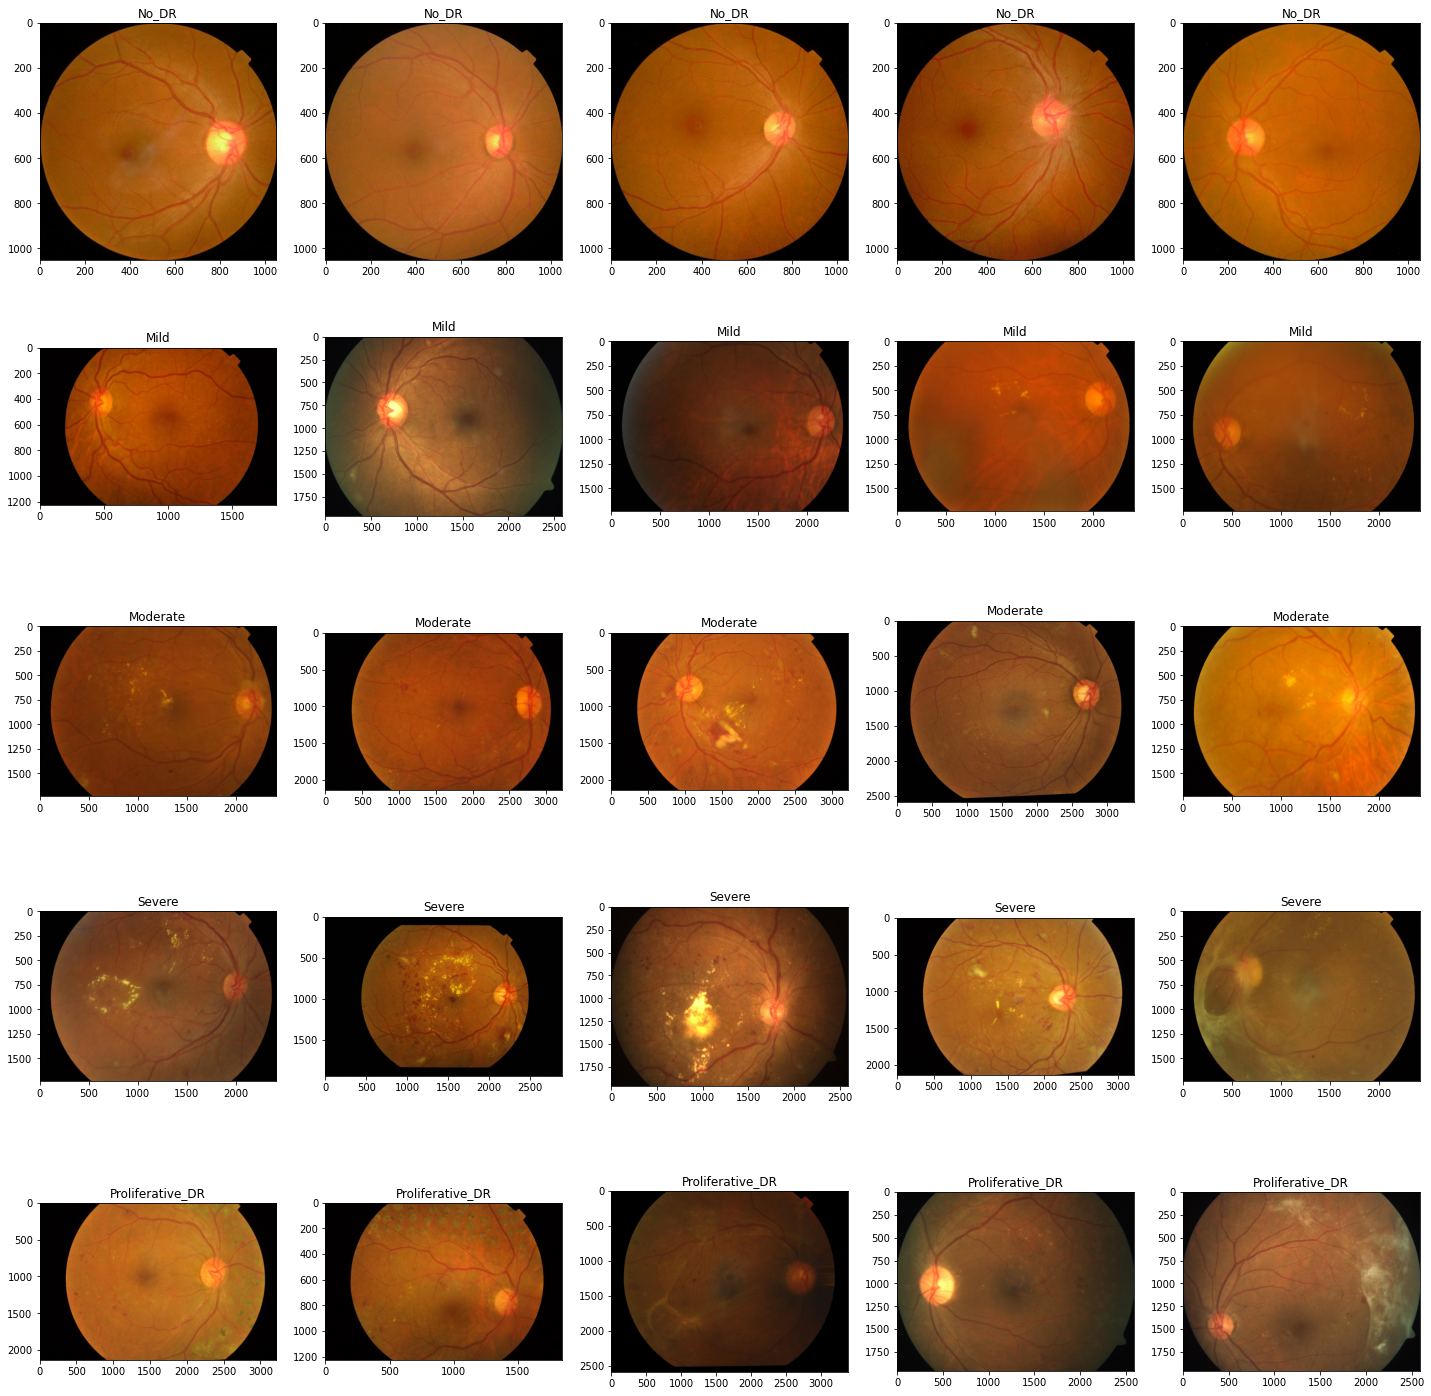

In [62]:
fig, ax = plt.subplots(5,5, figsize = (20,20))
count = 0
for i in labels:
    train_class = os.listdir(os.path.join('./aptos2019-blindness-detection/train_images/',i))
    for j in range(5):
        img = os.path.join('./aptos2019-blindness-detection/train_images/',i,train_class[j])
        img = PIL.Image.open(img)
        ax[count][j].title.set_text(i)
        ax[count][j].imshow(img)
    count += 1
fig.tight_layout()

In [63]:
# check the number of images in each class in the training dataset

no_images_per_class = []
class_name = []
for i in labels:
    train_class = os.listdir(os.path.join('./aptos2019-blindness-detection/train_images/',i))
    no_images_per_class.append(len(train_class))
    class_name.append(i)
    print('Number of images in {} = {}\n'.format(i, len(train_class)))

Number of images in No_DR = 1805

Number of images in Mild = 370

Number of images in Moderate = 999

Number of images in Severe = 193

Number of images in Proliferative_DR = 295



In [112]:
# create a dataframe of image paths and their labels
train_img_paths = []
train_labels = []

for i in labels:
    train_class = os.listdir(os.path.join('./aptos2019-blindness-detection/train_images/',i))
    for j in train_class:
        img = os.path.join('/Users/gurjinderkaur/Documents/Diabetic retinopathy/aptos2019-blindness-detection/train_images/',i,j)
        train_img_paths.append(img)
        train_labels.append(i)

retina_df = pd.DataFrame({'Image': train_img_paths, 'Label': train_labels})

In [113]:
retina_df.head()

,Image,Label
0,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
1,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
2,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
3,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
4,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR


### Perform data augmentation and create data generator

In [114]:
retina_df = shuffle(retina_df)
retina_df.head()

,Image,Label
1685,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
1012,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
2671,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate
1101,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
2753,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate


In [115]:
train, test = train_test_split(retina_df, test_size=0.2)

In [116]:
train

,Image,Label
3222,/Users/gurjinderkaur/Documents/Diabetic retino...,Severe
167,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
3295,/Users/gurjinderkaur/Documents/Diabetic retino...,Severe
960,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
2869,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate
...,...,...
2994,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate
1273,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
1314,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
1721,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR


In [117]:
test

,Image,Label
891,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
114,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
3655,/Users/gurjinderkaur/Documents/Diabetic retino...,Proliferative_DR
1339,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
103,/Users/gurjinderkaur/Documents/Diabetic retino...,No_DR
...,...,...
2555,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate
3633,/Users/gurjinderkaur/Documents/Diabetic retino...,Proliferative_DR
2325,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate
2715,/Users/gurjinderkaur/Documents/Diabetic retino...,Moderate


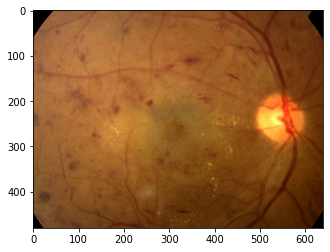

In [120]:
im = PIL.Image.open(test['Image'][3352])
plt.imshow(im)
# /Users/gurjinderkaur/Documents/Diabetic retinopathy/aptos2019-blindness-detection/train_images/Severe/0cb14014117d.png

In [121]:
# create run-time augmentation on training and test data
# for training data generator, we add normalization, shear angle, horizontal flip and zooming range

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  validation_split=0.15)

# for testing datagenerator, we only normalize the data
test_datagen = ImageDataGenerator(rescale=1./255)


In [123]:
# creating datagenerator for training, validation and test datasets

train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = None,
                                                    x_col='Image',
                                                    y_col='Label',
                                                    target_size=(256,256),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training')
                                                   

validation_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = None,
                                                    x_col='Image',
                                                    y_col='Label',
                                                    target_size=(256,256),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation')

test_generator = test_datagen.flow_from_dataframe(test,
                                                   directory = None,
                                                    x_col='Image',
                                                    y_col='Label',
                                                    target_size=(256,256),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32)
                                                    



Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


## Build Res-block based model

In [125]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [132]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Compile and train the model

In [134]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [136]:
earlystopping = EarlyStopping(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=15)

In [138]:
# save the best model with lowest validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hd5',
                              verbose = 1,
                              save_best_only = True)

In [139]:
history = model.fit(train_generator,
                   steps_per_epoch=train_generator.n//32,
                   epochs = 1,
                   validation_data=validation_generator,
                   validation_steps=validation_generator.n//32,
                   callbacks=[checkpointer,earlystopping])

2022-03-24 23:05:15.550549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 4 of 78
2022-03-24 23:05:26.186766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 78
2022-03-24 23:05:32.876944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 9 of 78
2022-03-24 23:05:45.440755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 13 of 78
2022-03-24 23:05:54.807030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 78
2022-03-24 23:06:04.148341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 19 of 78
2022-03-24 23:06:13.174267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take 

Train for 77 steps, validate for 13 steps


2022-03-24 23:09:37.687310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 4 of 78
2022-03-24 23:09:48.350370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 7 of 78
2022-03-24 23:09:55.161027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 9 of 78
2022-03-24 23:10:05.038606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 12 of 78
2022-03-24 23:10:17.509913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 16 of 78
2022-03-24 23:10:26.966018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 19 of 78
2022-03-24 23:10:36.206676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take 

76/77 [============================>.] - ETA: 10s - loss: 1.4267 - accuracy: 0.6500
Epoch 00001: val_loss improved from inf to 1.57463, saving model to weights.hd5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: weights.hd5/assets
77/77 [==============================] - 904s 12s/step - loss: 1.4201 - accuracy: 0.6505 - val_loss: 1.5746 - val_accuracy: 0.2524


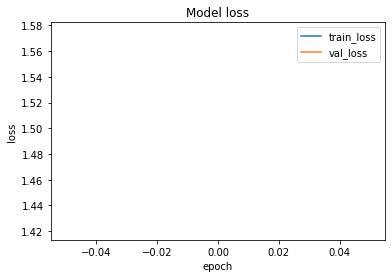

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [142]:
model.load_weights("weights.hdf5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)